In [4]:
CLOUD = True

import sys

from pathlib import Path
from PIL import ImageDraw, ImageFont, Image
from matplotlib import patches, patheffects
import time
from random import randint
import numpy as np
import pandas as pd
import pickle

from sklearn.model_selection import KFold, StratifiedKFold, GroupKFold
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, LabelBinarizer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error,log_loss
from scipy.stats import ks_2samp

import pdb

import scipy as sp
from tqdm import tqdm, tqdm_notebook

import os
import glob

import torch
if not CLOUD: torch.cuda.current_device()

import torch.nn as nn
import torch.utils.data as D
import torch.nn.functional as F
import torch.utils as U

import torchvision
from torchvision import transforms as T
from torchvision import models as M

import matplotlib.pyplot as plt

if CLOUD:
    PATH = Path('/home/zahar_chikishev')
    PATH_WORK = Path('/home/zahar_chikishev/running')
else:
    PATH = Path('C:/StudioProjects/Hemorrhage')
    PATH_WORK = Path('C:/StudioProjects/Hemorrhage/running')

if not CLOUD:
    import lightgbm as lgb
    from eli5.permutation_importance import get_score_importances

from collections import defaultdict, Counter
import random
import seaborn as sn

pd.set_option("display.max_columns", 100)

all_ich = ['any','epidural','intraparenchymal','intraventricular','subarachnoid','subdural']

In [3]:
sys.path.insert(0, "C:\\fastai")
from fastai import *
from fastai.vision import *
from fastai.tabular import *
from fastprogress import *

In [48]:
train_df = pd.read_csv(PATH_WORK/'train_df.csv')
train_md = pd.read_csv(PATH_WORK/'train_md.csv')
test_md = pd.read_csv(PATH_WORK/'test_md.csv')

# Prepare meta data

In [7]:
train_csv = pd.read_csv(PATH/'stage_1_train.csv')

train_csv = train_csv.loc[~train_csv.ID.duplicated()].sort_values('ID').reset_index(drop=True)
all_sop_ids = train_csv.ID.str.split('_').apply(lambda x: x[0]+'_'+x[1]).unique()
train_df = pd.DataFrame(train_csv.Label.values.reshape((-1,6)), columns = all_ich)
train_df['sop_id'] = all_sop_ids

train_df.to_csv(PATH_WORK/'train_df.csv', index=False)

In [8]:
train_md = pd.read_csv(PATH/'train_metadata.csv')
test_md = pd.read_csv(PATH/'test_metadata.csv')
test_md = test_md.sort_values('SOPInstanceUID')
data_md = pd.concat([train_md, test_md], axis=0, sort=False).reset_index(drop=True)

In [9]:
del data_md['Unnamed: 0']

for i in range(6):
    data_md['ImageOrientationPatient_{}'.format(i)] \
        = data_md['ImageOrientationPatient'].str.split('\'').apply(lambda x: x[1+2*i])

for i in range(3):
    data_md['ImagePositionPatient_{}'.format(i)] \
        = data_md['ImagePositionPatient'].str.split('\'').apply(lambda x: x[1+2*i])

for i in range(2):
    data_md['PixelSpacing_{}'.format(i)] \
        = data_md['PixelSpacing'].str.split('\'').apply(lambda x: x[1+2*i])

data_md['WindowCenter_0'] \
    = data_md['WindowCenter'].str.split('\'').apply(lambda x: float(x[1]) if len(x) > 1 else float(x[0]))

data_md['WindowCenter_1'] \
    = data_md['WindowCenter'].str.split('\'').apply(lambda x: float(x[3]) if len(x) > 1 else np.nan)

data_md['WindowCenter_1_NAN'] = data_md.WindowCenter_1.isnull()

data_md.loc[data_md.WindowCenter_1.isnull(), 'WindowCenter_1'] \
    = data_md.loc[~data_md.WindowCenter_1.isnull(), 'WindowCenter_1'].mean()

In [30]:
data_md['ImagePositionPatient_2'] = data_md['ImagePositionPatient_2'].astype(float)

data_md = data_md.sort_values(['SeriesInstanceUID','ImagePositionPatient_2']).reset_index(drop=True)

In [31]:
data_md['pos_max'] = data_md[['SeriesInstanceUID','ImagePositionPatient_2']]\
    .groupby('SeriesInstanceUID').transform(lambda x: max(x))
data_md['pos_min'] = data_md[['SeriesInstanceUID','ImagePositionPatient_2']]\
    .groupby('SeriesInstanceUID').transform(lambda x: min(x))
data_md['pos_size'] = data_md[['SeriesInstanceUID','ImagePositionPatient_2']]\
    .groupby('SeriesInstanceUID').transform(lambda x: len(x))

data_md['pos_idx'] = data_md[['SeriesInstanceUID','ImagePositionPatient_2']]\
    .groupby('SeriesInstanceUID').transform(lambda x: np.arange(len(x)))

data_md['pos_inc'] = data_md[['SeriesInstanceUID','ImagePositionPatient_2']]\
    .groupby('SeriesInstanceUID').transform(lambda x: np.concatenate([[0],np.diff(x.values)]))

In [32]:
data_md['pos_range'] = (data_md['pos_max'] - data_md['pos_min'])
data_md['pos_rel'] = (data_md['ImagePositionPatient_2'] - data_md['pos_min'])/data_md['pos_range']

In [33]:
data_md['pos_zeros'] = data_md[['SeriesInstanceUID','ImagePositionPatient_2']]\
    .groupby('SeriesInstanceUID').transform(lambda x: (np.diff(x.values) <= 0.001).sum())

In [34]:
data_md['pos_inc_rng'] = data_md[['SeriesInstanceUID','ImagePositionPatient_2']]\
    .groupby('SeriesInstanceUID').transform(lambda x: np.diff(x.values)[np.diff(x.values) > 0.1].max() /
                                                      np.diff(x.values)[np.diff(x.values) > 0.1].min())
data_md['pos_inc_rng'] = np.clip(data_md['pos_inc_rng'],0,6)

In [35]:
data_md = data_md.sort_values('SOPInstanceUID').reset_index(drop=True)

In [36]:
cols_cat = ['BitsStored','PixelRepresentation','RescaleIntercept','WindowCenter_1_NAN']
cols_float = ['ImageOrientationPatient_0', 'ImageOrientationPatient_1',
       'ImageOrientationPatient_2', 'ImageOrientationPatient_3',
       'ImageOrientationPatient_4', 'ImageOrientationPatient_5',
       'ImagePositionPatient_0', 'ImagePositionPatient_1','ImagePositionPatient_2',
       'PixelSpacing_0', 'PixelSpacing_1', 'WindowCenter_0', 'WindowCenter_1',
       'pos_max', 'pos_min', 'pos_size', 'pos_idx', 'pos_inc',
       'pos_range', 'pos_rel', 'pos_zeros', 'pos_inc_rng']
pickle.dump((cols_cat,cols_float), open(PATH_WORK/'covs','wb'))

In [37]:
for col in cols_float:
    data_md[col] = data_md[col].astype(float)

for col in cols_cat:
    data_md[col] = pd.factorize(data_md[col])[0]
    data_md[col] = data_md[col].astype('category')

In [41]:
data_md = data_md.join(train_df.set_index('sop_id'), on = 'SOPInstanceUID')

In [42]:
for col in cols_cat:
    print(pd.crosstab(data_md[col], data_md['any'].isnull()))

any          False  True 
BitsStored               
0           341679  75369
1           332579   3176
any                   False  True 
PixelRepresentation               
0                    343931  75429
1                    330327   3116
any                False  True 
RescaleIntercept               
0                 662279  78457
1                   6653     28
2                   5276     60
3                     50      0
any                  False  True 
WindowCenter_1_NAN               
0                   341679  75369
1                   332579   3176


In [43]:
train_md = data_md.loc[~data_md['any'].isnull()].copy().reset_index(drop=True)
for col in all_ich:
    train_md[col] = train_md[col].astype(int)
train_md.to_csv(PATH_WORK/'train_md.csv', index=False)

test_md = data_md.loc[data_md['any'].isnull()].copy().reset_index(drop=True)
test_md.to_csv(PATH_WORK/'test_md.csv', index=False)

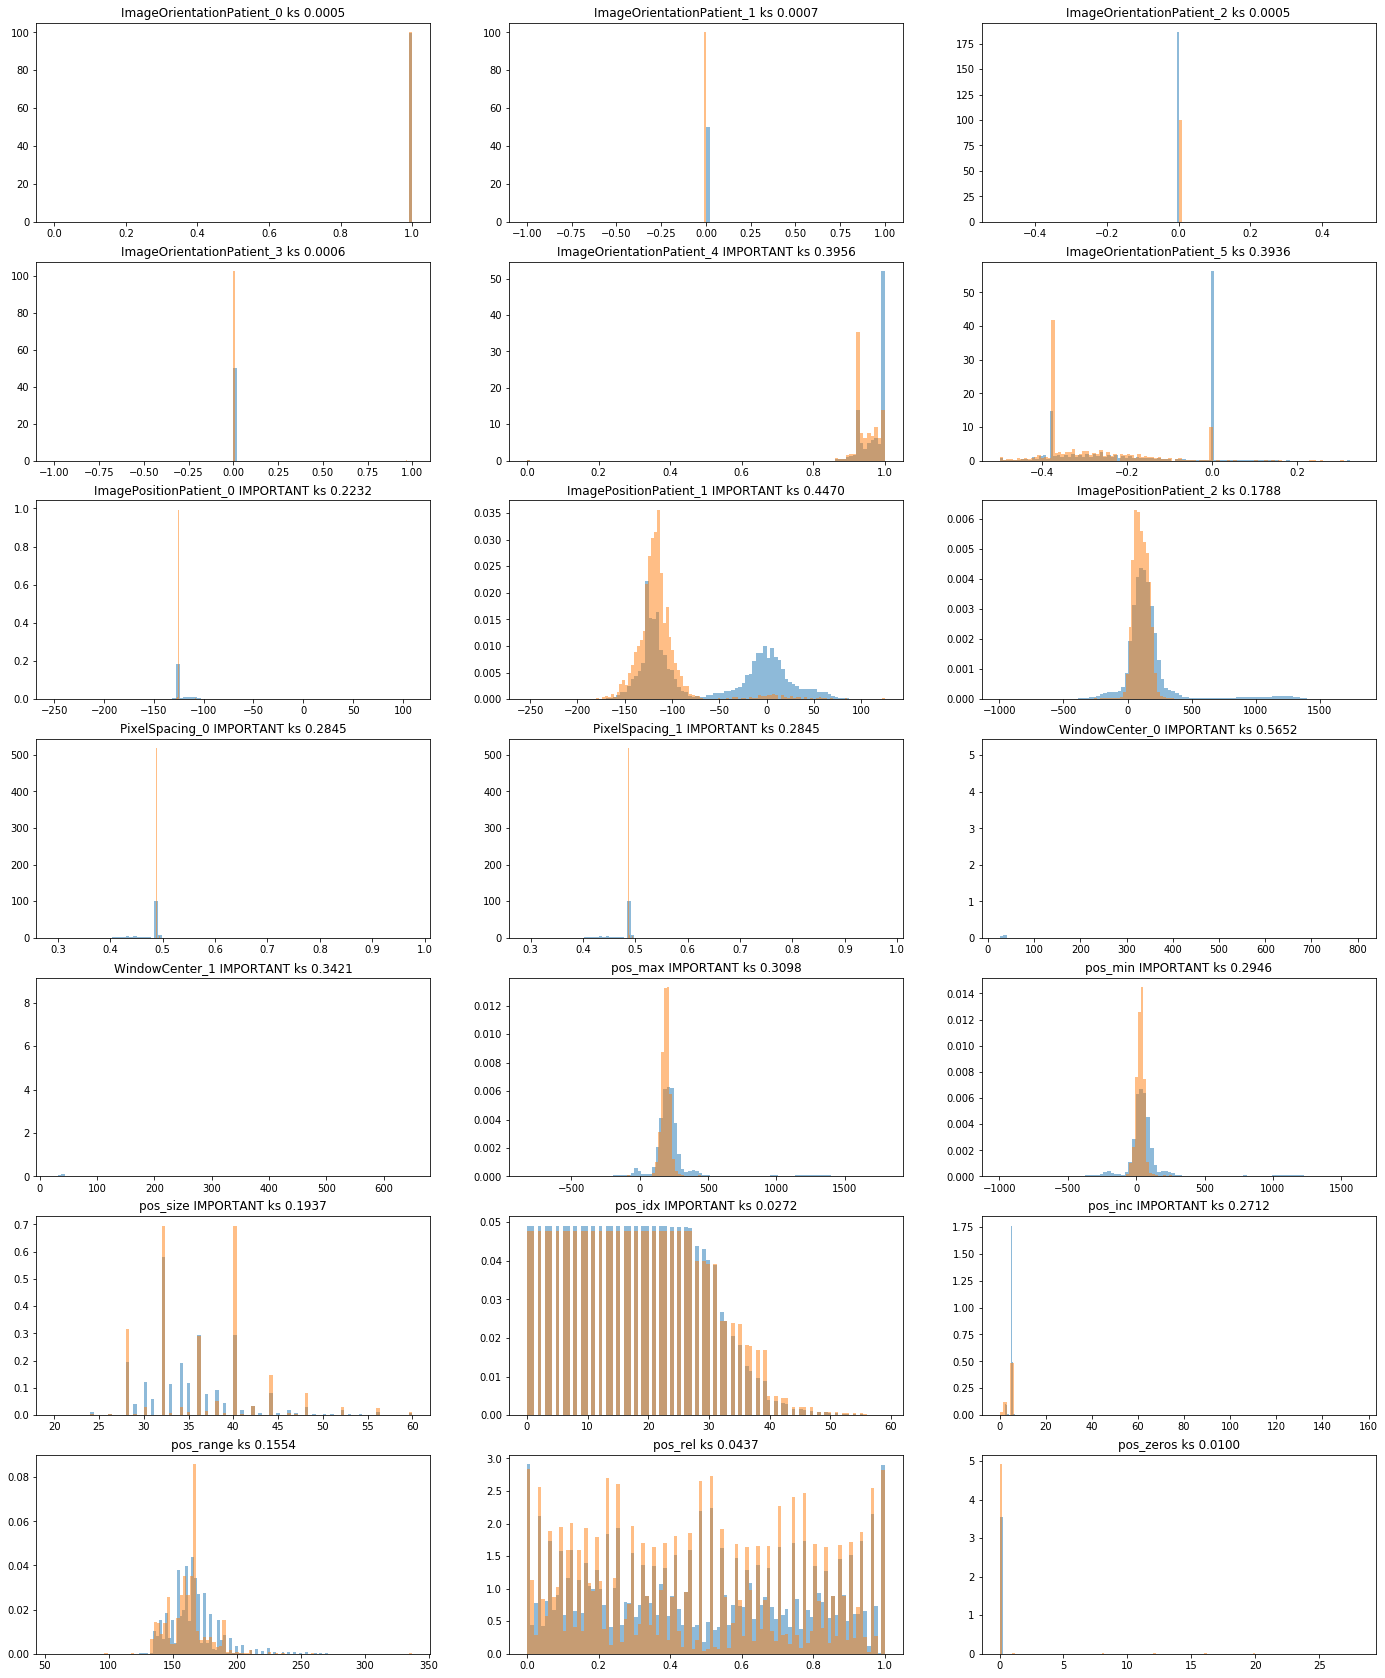

In [47]:
fig, axes = plt.subplots(7, 3, figsize=(24, 30))

for i, ax in enumerate(axes.flatten()):
    if i == len(cols_float): continue
    col = cols_float[i]
    a = ax.hist(train_md[col], bins=100, density=True, alpha=0.5)
    a = ax.hist(test_md[col], bins=100, density=True, alpha=0.5)
    ks = ks_2samp(train_md[col].values, test_md[col].values)
    ax.set_title(col + (' IMPORTANT' if col in significant_cols else '') + ' ks {:.4f}'.format(ks.statistic))

# Scans

In [103]:
train_md.head()

,BitsAllocated,BitsStored,HighBit,ImageOrientationPatient,ImagePositionPatient,Modality,PatientID,PhotometricInterpretation,PixelRepresentation,PixelSpacing,RescaleIntercept,RescaleSlope,SOPInstanceUID,SamplesPerPixel,SeriesInstanceUID,StudyID,StudyInstanceUID,WindowCenter,WindowWidth,ImageOrientationPatient_0,ImageOrientationPatient_1,ImageOrientationPatient_2,ImageOrientationPatient_3,ImageOrientationPatient_4,ImageOrientationPatient_5,ImagePositionPatient_0,ImagePositionPatient_1,ImagePositionPatient_2,PixelSpacing_0,PixelSpacing_1,WindowCenter_0,WindowCenter_1,WindowCenter_1_NAN,any,epidural,intraparenchymal,intraventricular,subarachnoid,subdural,weight
0,16,0,15,"['1.000000', '0.000000', '0.000000', '0.000000...","['-125.000', '-123.101', '104.307']",CT,ID_b81a287f,MONOCHROME2,0,"['0.488281', '0.488281']",0,1.0,ID_231d901c1,1,ID_15dcd6057a,NaN,ID_dd37ba3adb,40,100,1.0,0.0,0.0,0.0,0.984808,-0.173648,-125.0,-123.101000,104.307000,0.488281,0.488281,40.0,38.015255,0,1,0,0,0,1,0,0.015365
1,16,1,11,"['1', '0', '0', '0', '0.933580426', '-0.358367...","['-125', '53.6282216', '223.572015']",CT,ID_400facde,MONOCHROME2,1,"['0.48828125', '0.48828125']",0,1.0,ID_994bc0470,1,ID_4ba12c2161,NaN,ID_c5277f0c63,"['00047', '00047']","['00080', '00080']",1.0,0.0,0.0,0.0,0.933580,-0.358368,-125.0,53.628222,223.572015,0.488281,0.488281,47.0,47.000000,1,0,0,0,0,0,0,0.001997
2,16,0,15,"['1.000000', '0.000000', '0.000000', '0.000000...","['-125.000000', '-123.646240', '124.321068']",CT,ID_42910d3d,MONOCHROME2,0,"['0.488281', '0.488281']",0,1.0,ID_127689cce,1,ID_c4b4931314,NaN,ID_db93ade25b,30,80,1.0,0.0,0.0,0.0,0.972370,-0.233445,-125.0,-123.646240,124.321068,0.488281,0.488281,30.0,38.015255,0,0,0,0,0,0,0,0.269672
3,16,1,11,"['1', '0', '0', '0', '1', '0']","['-114', '-6', '171.999939']",CT,ID_329aafa7,MONOCHROME2,1,"['0.4453125', '0.4453125']",0,1.0,ID_25457734a,1,ID_116558f409,NaN,ID_8dd6d32f3b,"['00036', '00036']","['00080', '00080']",1.0,0.0,0.0,0.0,1.000000,0.000000,-114.0,-6.000000,171.999939,0.445312,0.445312,36.0,36.000000,1,0,0,0,0,0,0,0.003259
4,16,1,11,"['1', '0', '0', '0', '1', '0']","['-115', '-1', '230.5']",CT,ID_6b544c3c,MONOCHROME2,1,"['0.44921875', '0.44921875']",0,1.0,ID_81c9aa125,1,ID_f56d7bd0f9,NaN,ID_2685c5d5c0,"['00036', '00036']","['00080', '00080']",1.0,0.0,0.0,0.0,1.000000,0.000000,-115.0,-1.000000,230.500000,0.449219,0.449219,36.0,36.000000,1,0,0,0,0,0,0,0.005538


In [151]:
train_md.loc[train_md.SeriesInstanceUID == 'ID_025d684f04']

,BitsAllocated,BitsStored,HighBit,ImageOrientationPatient,ImagePositionPatient,Modality,PatientID,PhotometricInterpretation,PixelRepresentation,PixelSpacing,RescaleIntercept,RescaleSlope,SOPInstanceUID,SamplesPerPixel,SeriesInstanceUID,StudyID,StudyInstanceUID,WindowCenter,WindowWidth,ImageOrientationPatient_0,ImageOrientationPatient_1,ImageOrientationPatient_2,ImageOrientationPatient_3,ImageOrientationPatient_4,ImageOrientationPatient_5,ImagePositionPatient_0,ImagePositionPatient_1,ImagePositionPatient_2,PixelSpacing_0,PixelSpacing_1,WindowCenter_0,WindowCenter_1,WindowCenter_1_NAN,any,epidural,intraparenchymal,intraventricular,subarachnoid,subdural,weight,pos_max,pos_min,pos_size,pos_idx,pos_inc
6173,16,0,15,"['1.000000', '0.000000', '0.000000', '0.000000...","['-125.000000', '-107.097977', '18.730394']",CT,ID_6a88f066,MONOCHROME2,0,"['0.488281', '0.488281']",0,1.0,ID_fca334534,1,ID_025d684f04,NaN,ID_75eaa2e6de,30,80,1.0,0.0,0.0,0.0,0.927184,-0.374607,-125.0,-107.097977,18.730394,0.488281,0.488281,30.0,38.015255,0,0,0,0,0,0,0,0.210224,185.898392,18.730394,36,0,0.000000
6174,16,0,15,"['1.000000', '0.000000', '0.000000', '0.000000...","['-125.000000', '-107.097977', '24.123068']",CT,ID_6a88f066,MONOCHROME2,0,"['0.488281', '0.488281']",0,1.0,ID_bb3ca1577,1,ID_025d684f04,NaN,ID_75eaa2e6de,30,80,1.0,0.0,0.0,0.0,0.927184,-0.374607,-125.0,-107.097977,24.123068,0.488281,0.488281,30.0,38.015255,0,0,0,0,0,0,0,0.210186,185.898392,18.730394,36,1,5.392674
6175,16,0,15,"['1.000000', '0.000000', '0.000000', '0.000000...","['-125.000000', '-107.097977', '29.515741']",CT,ID_6a88f066,MONOCHROME2,0,"['0.488281', '0.488281']",0,1.0,ID_78ce791af,1,ID_025d684f04,NaN,ID_75eaa2e6de,30,80,1.0,0.0,0.0,0.0,0.927184,-0.374607,-125.0,-107.097977,29.515741,0.488281,0.488281,30.0,38.015255,0,0,0,0,0,0,0,0.212440,185.898392,18.730394,36,2,5.392673
6176,16,0,15,"['1.000000', '0.000000', '0.000000', '0.000000...","['-125.000000', '-107.097977', '34.908417']",CT,ID_6a88f066,MONOCHROME2,0,"['0.488281', '0.488281']",0,1.0,ID_3c9c2db71,1,ID_025d684f04,NaN,ID_75eaa2e6de,30,80,1.0,0.0,0.0,0.0,0.927184,-0.374607,-125.0,-107.097977,34.908417,0.488281,0.488281,30.0,38.015255,0,0,0,0,0,0,0,0.201545,185.898392,18.730394,36,3,5.392676
6177,16,0,15,"['1.000000', '0.000000', '0.000000', '0.000000...","['-125.000000', '-107.097977', '40.300396']",CT,ID_6a88f066,MONOCHROME2,0,"['0.488281', '0.488281']",0,1.0,ID_069d12e61,1,ID_025d684f04,NaN,ID_75eaa2e6de,30,80,1.0,0.0,0.0,0.0,0.927184,-0.374607,-125.0,-107.097977,40.300396,0.488281,0.488281,30.0,38.015255,0,0,0,0,0,0,0,0.206333,185.898392,18.730394,36,4,5.391979
6178,16,0,15,"['1.000000', '0.000000', '0.000000', '0.000000...","['-125.000000', '-107.097977', '45.693069']",CT,ID_6a88f066,MONOCHROME2,0,"['0.488281', '0.488281']",0,1.0,ID_7bdb10aaa,1,ID_025d684f04,NaN,ID_75eaa2e6de,30,80,1.0,0.0,0.0,0.0,0.927184,-0.374607,-125.0,-107.097977,45.693069,0.488281,0.488281,30.0,38.015255,0,0,0,0,0,0,0,0.199955,185.898392,18.730394,36,5,5.392673
6179,16,0,15,"['1.000000', '0.000000', '0.000000', '0.000000...","['-125.000000', '-107.097977', '51.085743']",CT,ID_6a88f066,MONOCHROME2,0,"['0.488281', '0.488281']",0,1.0,ID_be063f884,1,ID_025d684f04,NaN,ID_75eaa2e6de,30,80,1.0,0.0,0.0,0.0,0.927184,-0.374607,-125.0,-107.097977,51.085743,0.488281,0.488281,30.0,38.015255,0,0,0,0,0,0,0,0.198593,185.898392,18.730394,36,6,5.392674
6180,16,0,15,"['1.000000', '0.000000', '0.000000', '0.000000...","['-125.000000', '-107.097977', '56.478416']",CT,ID_6a88f066,MONOCHROME2,0,"['0.488281', '0.488281']",0,1.0,ID_464557fbf,1,ID_025d684f04,NaN,ID_75eaa2e6de,30,80,1.0,0.0,0.0,0.0,0.927184,-0.374607,-125.0,-107.097977,56.478416,0.488281,0.488281,30.0,38.015255,0,0,0,0,0,0,0,0.200670,185.898392,18.730394,36,7,5.392673
6181,16,0,15,"['1.000000', '0.000000', '0.000000', '0.000000...","['-125.000000', '-107.097977', '61.870396']",CT,ID_6a88f066,MONOCHROME2,0,"['0.488281', '0.488281']",0,1.0,ID_ec73321eb,1,ID_025d684f04,NaN,ID_75eaa2e6de,30,80,1.0,0.0,0.0,0.0,0.9

In [104]:
len(train_md.SeriesInstanceUID.unique())

19530

In [106]:
len(train_md.PatientID.unique())

17079

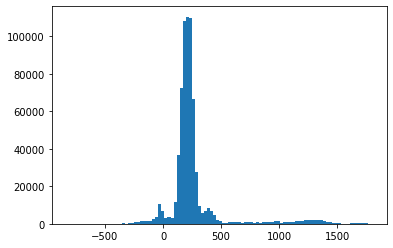

In [136]:
a = plt.hist(train_md.pos_max,bins=100)

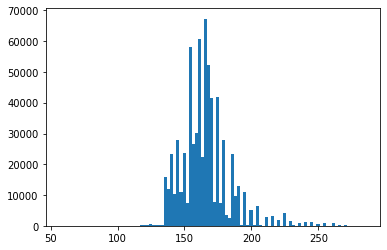

In [137]:
a = plt.hist(train_md.pos_max - train_md.pos_min,bins=100)

In [141]:
train_md.pos_size.value_counts().head()

32    156544
40     79080
36     78912
28     52220
34     51510
Name: pos_size, dtype: int64

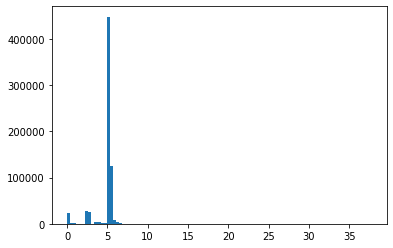

In [145]:
a = plt.hist(train_md.pos_inc,bins=100)

In [150]:
train_md.loc[(train_md.pos_inc == 0) & (train_md.pos_idx != 0)].head()

,BitsAllocated,BitsStored,HighBit,ImageOrientationPatient,ImagePositionPatient,Modality,PatientID,PhotometricInterpretation,PixelRepresentation,PixelSpacing,RescaleIntercept,RescaleSlope,SOPInstanceUID,SamplesPerPixel,SeriesInstanceUID,StudyID,StudyInstanceUID,WindowCenter,WindowWidth,ImageOrientationPatient_0,ImageOrientationPatient_1,ImageOrientationPatient_2,ImageOrientationPatient_3,ImageOrientationPatient_4,ImageOrientationPatient_5,ImagePositionPatient_0,ImagePositionPatient_1,ImagePositionPatient_2,PixelSpacing_0,PixelSpacing_1,WindowCenter_0,WindowCenter_1,WindowCenter_1_NAN,any,epidural,intraparenchymal,intraventricular,subarachnoid,subdural,weight,pos_max,pos_min,pos_size,pos_idx,pos_inc
6182,16,0,15,"['1.000000', '0.000000', '0.000000', '0.000000...","['-125.000000', '-107.097977', '61.870396']",CT,ID_6a88f066,MONOCHROME2,0,"['0.488281', '0.488281']",0,1.0,ID_0e67917f5,1,ID_025d684f04,NaN,ID_75eaa2e6de,30,80,1.0,0.0,0.0,0.0,0.927184,-0.374607,-125.0,-107.097977,61.870396,0.488281,0.488281,30.0,38.015255,0,0,0,0,0,0,0,0.200965,185.898392,18.730394,36,9,0.0
6184,16,0,15,"['1.000000', '0.000000', '0.000000', '0.000000...","['-125.000000', '-107.097977', '67.263069']",CT,ID_6a88f066,MONOCHROME2,0,"['0.488281', '0.488281']",0,1.0,ID_c7605edce,1,ID_025d684f04,NaN,ID_75eaa2e6de,30,80,1.0,0.0,0.0,0.0,0.927184,-0.374607,-125.0,-107.097977,67.263069,0.488281,0.488281,30.0,38.015255,0,0,0,0,0,0,0,0.197010,185.898392,18.730394,36,11,0.0
6186,16,0,15,"['1.000000', '0.000000', '0.000000', '0.000000...","['-125.000000', '-107.097977', '72.655739']",CT,ID_6a88f066,MONOCHROME2,0,"['0.488281', '0.488281']",0,1.0,ID_12683d977,1,ID_025d684f04,NaN,ID_75eaa2e6de,30,80,1.0,0.0,0.0,0.0,0.927184,-0.374607,-125.0,-107.097977,72.655739,0.488281,0.488281,30.0,38.015255,0,0,0,0,0,0,0,0.204350,185.898392,18.730394,36,13,0.0
6188,16,0,15,"['1.000000', '0.000000', '0.000000', '0.000000...","['-125.000000', '-107.097977', '78.048416']",CT,ID_6a88f066,MONOCHROME2,0,"['0.488281', '0.488281']",0,1.0,ID_6f53ceeb2,1,ID_025d684f04,NaN,ID_75eaa2e6de,30,80,1.0,0.0,0.0,0.0,0.927184,-0.374607,-125.0,-107.097977,78.048416,0.488281,0.488281,30.0,38.015255,0,0,0,0,0,0,0,0.196889,185.898392,18.730394,36,15,0.0
23316,16,0,15,"['1.000000', '0.000000', '0.000000', '0.000000...","['-125.000', '-100.476', '67.115']",CT,ID_90c32ee5,MONOCHROME2,0,"['0.488281', '0.488281']",0,1.0,ID_057386df0,1,ID_08f1a9df80,NaN,ID_e329fba98e,40,150,1.0,0.0,0.0,0.0,0.891007,-0.453990,-125.0,-100.476000,67.115000,0.488281,0.488281,40.0,38.015255,0,1,0,0,0,0,1,0.018081,156.895000,-17.055000,40,16,0.0


In [292]:
grp = pd.qcut(train_md['pos_rel'],30,duplicates='drop')
x = train_md['pos_rel'].groupby(grp).mean()

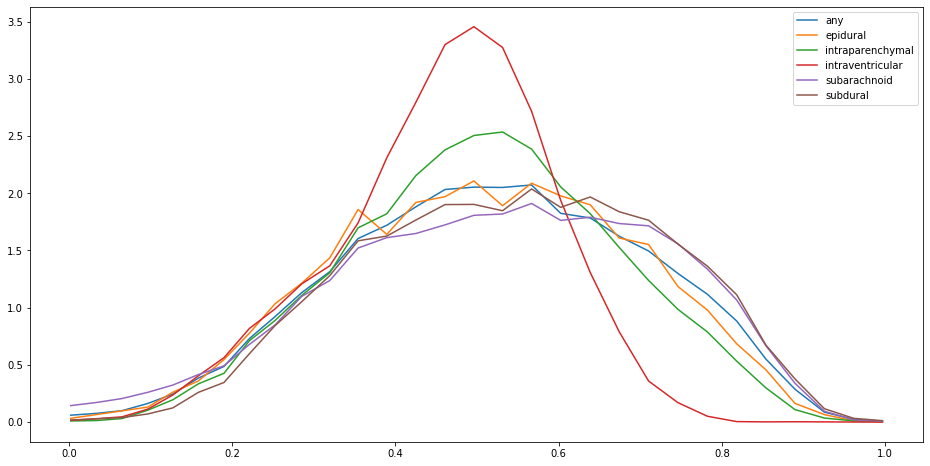

In [303]:
plt.figure(figsize=(16, 8))
for col in all_ich:
    ww = train_md[col].mean()
    plt.plot(x, train_md[col].groupby(grp).mean().values / ww)
plt.legend(all_ich)

# Matching weights

In [193]:
data_md['weight'] = 1

for k in range(3):
    #for col in ['PixelSpacing_0']:
    for col in significant_cols:

        if len(data_md[col].unique()) <= 100:
            data_md['grp_weight'] = data_md[col]
        else:
            data_md['grp_weight'] = pd.qcut(data_md[col],100,duplicates='drop')

        ww = data_md[['grp_weight','any','weight']].groupby('grp_weight')\
            .apply(lambda x: x['any'].isnull().sum()/((x.weight[~x['any'].isnull()]).sum() + 1e-6))
        ww = pd.DataFrame(ww, columns = ['weight_fac'])
        print(ww.head())
        
        data_md = data_md.join(ww, on = 'grp_weight')
        data_md.loc[~data_md['any'].isnull(),'weight'] *= data_md.loc[~data_md['any'].isnull(),'weight_fac']

        del data_md['weight_fac']
        del data_md['grp_weight']

            weight_fac
grp_weight            
0             0.220584
1             0.009550
            weight_fac
grp_weight            
0             1.000511
1             0.987797
            weight_fac
grp_weight            
0             0.999490
1             1.012266
                      weight_fac
grp_weight                      
(-1e-07, 0.882948]      1.057270
(0.882948, 0.898794]    1.072048
(0.898794, 0.906308]    0.897005
(0.906308, 0.913545]    1.186886
(0.913545, 0.91706]     0.826138
                    weight_fac
grp_weight                    
(-250.001, -155.0]    1.129195
(-155.0, -146.0]      1.463599
(-146.0, -139.5]      1.610627
(-139.5, -135.9]      1.948982
(-135.9, -133.0]      1.353873
                        weight_fac
grp_weight                        
(-253.40001, -153.887]    1.332844
(-153.887, -147.3]        1.416284
(-147.3, -143.661]        1.023889
(-143.661, -141.03061]    0.918627
(-141.03061, -138.637]    1.180680
                               

(-176.8, -121.524]      1.147310
            weight_fac
grp_weight            
20.0          1.966588
21.0          0.000000
22.0          0.000000
23.0          0.000000
24.0          1.025124
            weight_fac
grp_weight            
0.0           0.997354
1.0           1.009193
2.0           1.009555
3.0           1.008279
4.0           1.005987
                           weight_fac
grp_weight                           
(-1e-14, 2.443]              1.002834
(2.443, 2.51623530000001]    0.980900
(2.51623530000001, 2.551]    1.014221
(2.551, 2.58799999999999]    0.996848
(2.58799999999999, 2.621]    0.979687


In [194]:
train_md = data_md.loc[~data_md['any'].isnull()].copy().reset_index(drop=True)
for col in all_ich:
    train_md[col] = train_md[col].astype(int)

test_md = data_md.loc[data_md['any'].isnull()].copy().reset_index(drop=True)

In [195]:
train_md.to_csv(PATH_WORK/'train_md.csv', index=False)
test_md.to_csv(PATH_WORK/'test_md.csv', index=False)

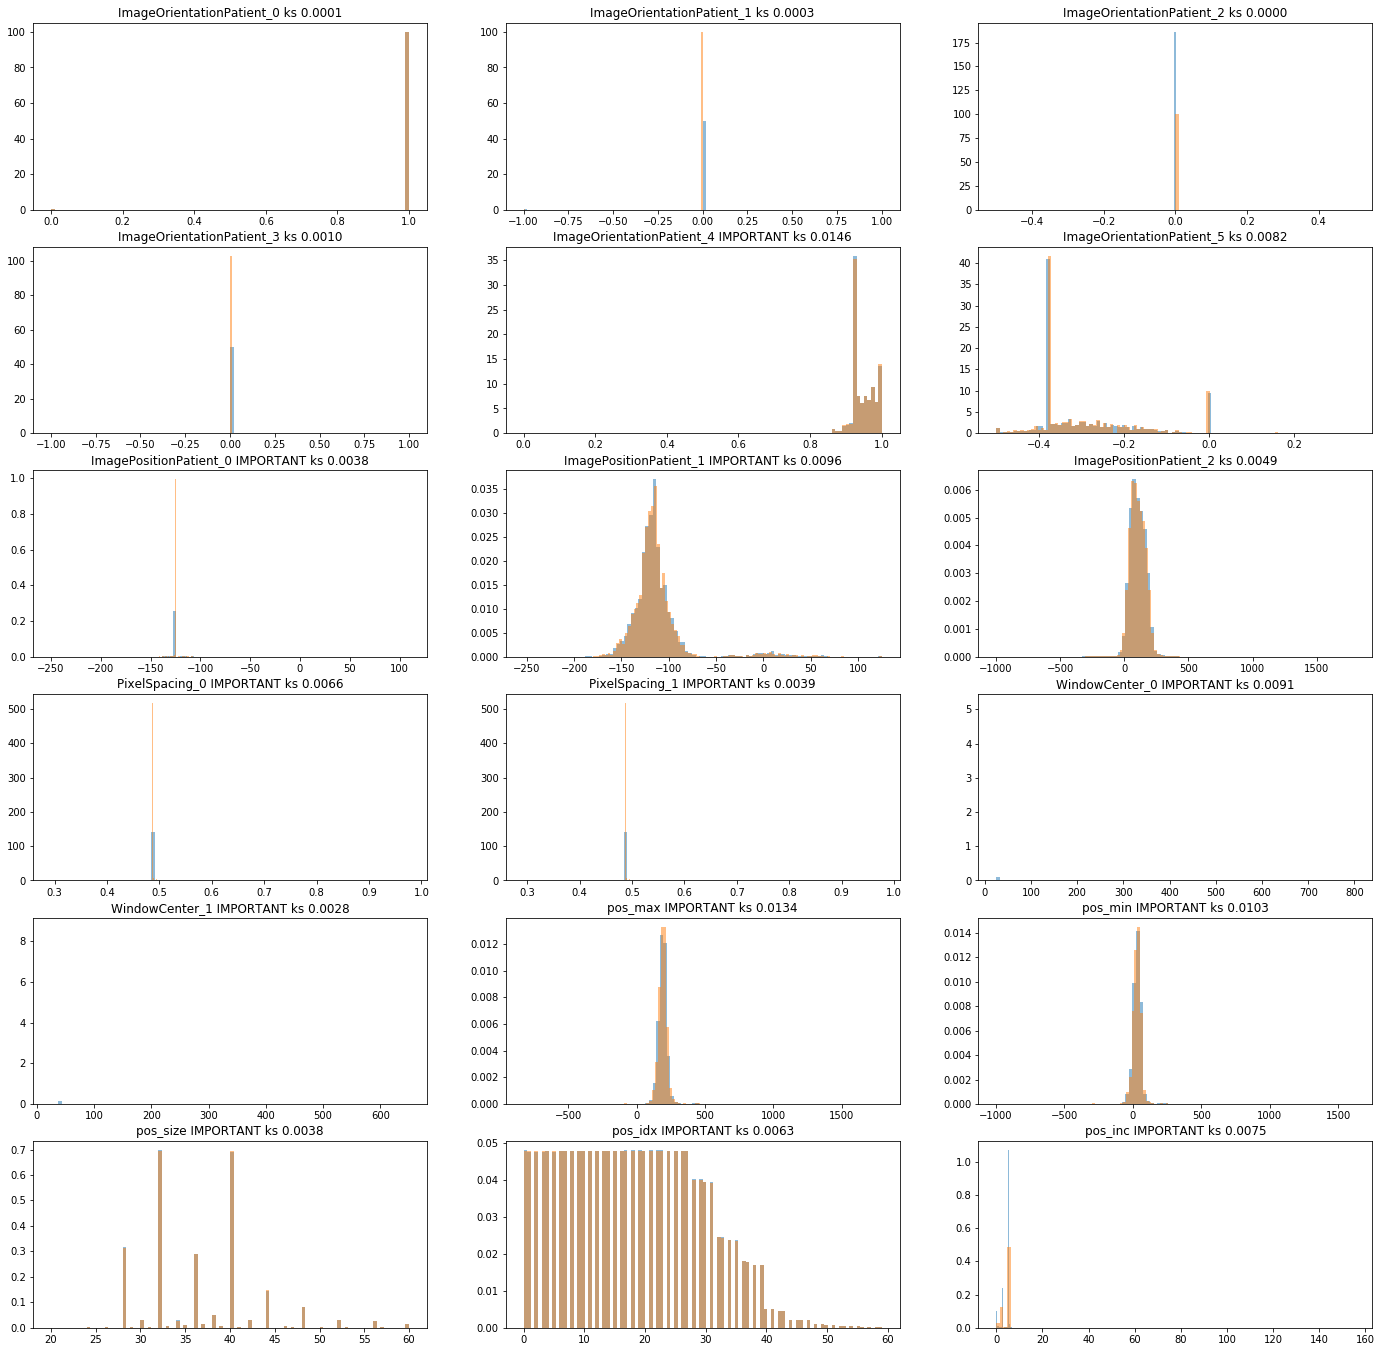

In [196]:
fig, axes = plt.subplots(6, 3, figsize=(24, 24))

for i, ax in enumerate(axes.flatten()):
    if i == len(cols_float): continue
    col = cols_float[i]
    a = ax.hist(train_md[col], bins=100, density=True, alpha=0.5, weights = train_md.weight)
    a = ax.hist(test_md[col], bins=100, density=True, alpha=0.5, weights = test_md.weight)
    sampled = np.random.choice(train_md[col].values,10000,p=train_md.weight/train_md.weight.sum())
    ks = ks_2samp(sampled, test_md[col].values)
    ax.set_title(col + (' IMPORTANT' if col in significant_cols else '') + ' ks {:.4f}'.format(ks.statistic))

In [197]:
(train_md.weight > 0.1).mean()

0.33090745678953754

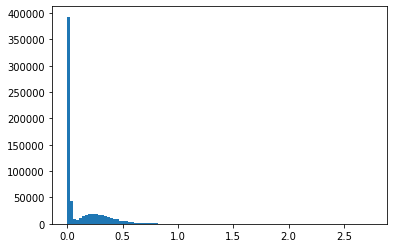

In [198]:
a = plt.hist(train_md.weight, bins=100)

# LightGBM

In [7]:
def stratified_group_k_fold(X, y, groups, k, seed=42):
    labels_num = np.max(y) + 1
    y_counts_per_group = defaultdict(lambda: np.zeros(labels_num))
    y_distr = Counter()
    for label, g in zip(y, groups):
        y_counts_per_group[g][label] += 1
        y_distr[label] += 1

    y_counts_per_fold = defaultdict(lambda: np.zeros(labels_num))
    groups_per_fold = defaultdict(set)

    def eval_y_counts_per_fold(y_counts, fold):
        y_counts_per_fold[fold] += y_counts
        std_per_label = []
        for label in range(labels_num):
            label_std = np.std([y_counts_per_fold[i][label] / y_distr[label] for i in range(k)])
            std_per_label.append(label_std)
        y_counts_per_fold[fold] -= y_counts
        return np.mean(std_per_label)
    
    groups_and_y_counts = list(y_counts_per_group.items())
    random.Random(seed).shuffle(groups_and_y_counts)

    for g, y_counts in sorted(groups_and_y_counts, key=lambda x: -np.std(x[1])):
        best_fold = None
        min_eval = None
        for i in range(k):
            fold_eval = eval_y_counts_per_fold(y_counts, i)
            if min_eval is None or fold_eval < min_eval:
                min_eval = fold_eval
                best_fold = i
        y_counts_per_fold[best_fold] += y_counts
        groups_per_fold[best_fold].add(g)

    all_groups = set(groups)
    for i in range(k):
        train_groups = all_groups - groups_per_fold[i]
        test_groups = groups_per_fold[i]

        train_indices = [i for i, g in enumerate(groups) if g in train_groups]
        test_indices = [i for i, g in enumerate(groups) if g in test_groups]

        yield train_indices, test_indices

In [8]:
params_lgb = {
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': {'binary_logloss'},
    'num_leaves': 96,
    'max_depth': 7,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.6,
    'bagging_freq': 1,
    'learning_rate': 0.05
}

In [29]:
class _Loss(Module):
    def __init__(self, size_average=None, reduce=None, reduction='mean'):
        super(_Loss, self).__init__()
        if size_average is not None or reduce is not None:
            self.reduction = _Reduction.legacy_get_string(size_average, reduce)
        else:
            self.reduction = reduction

class BCEWithLogitsLoss(_Loss):
    __constants__ = ['weight', 'pos_weight', 'reduction']

    def __init__(self, weight=None, size_average=None, reduce=None, reduction='mean', pos_weight=None):
        super(BCEWithLogitsLoss, self).__init__(size_average, reduce, reduction)
        self.register_buffer('weight', weight)
        self.register_buffer('pos_weight', pos_weight)

    def forward(self, input, target):
        return F.binary_cross_entropy_with_logits(input.squeeze(), target,
                                                  self.weight,
                                                  pos_weight=self.pos_weight,
                                                  reduction=self.reduction)

In [50]:
FOLDS = 3

def train_one(data = None, run_perm = False, target = 'qt', weight = None, group_col = None, method='lgb'):
    
    fi = pd.DataFrame()
    models = []
    
    my_seed = 1235
    random.seed(my_seed)
    np.random.seed(my_seed)
    
    for i, (dev_index, val_index) in enumerate(stratified_group_k_fold(
                data,data[target],groups=group_col,k=FOLDS,seed=my_seed)):
        data.loc[val_index,'fold'] = i
    
    data_filt = data.copy()
    del data_filt[target]
    
    predictions = np.zeros(len(data_filt))
    
    for i in range(FOLDS):
        
        Xt, Xv = data_filt.loc[data_filt['fold'] != i, :], data_filt.loc[data_filt['fold'] == i, :]
        yt, yv = data.loc[data_filt['fold'] != i, target], data.loc[data_filt['fold'] == i, target]
        Xt = Xt.drop('fold', axis=1)
        Xv = Xv.drop('fold', axis=1)
        
        wt = None
        wv = None
        if weight is not None:
            wt = weight[data_filt['fold'] != i]
            wv = weight[data_filt['fold'] == i]
        
        print('Fold', i, 'weight', np.sum(wt))
        
        if method == 'lgb':
            d_train = lgb.Dataset(Xt, yt, weight = wt)
            d_valid = lgb.Dataset(Xv, yv, weight = wv)

            watchlist = [d_train, d_valid]
            model = lgb.train(params_lgb,
                              train_set=d_train,
                              num_boost_round=200,
                              valid_sets=watchlist,
                              verbose_eval=10,
                              early_stopping_rounds=20)

            predictions[data_filt['fold'] == i] = model.predict(Xv, num_iteration=model.best_iteration)

            if run_perm:
                def eli_score(X, y):
                    y_pred = model.predict(X, num_iteration=model.best_iteration)
                    return np.abs(np.clip(y_pred,0,14) - y).mean()

                base_score, score_decreases = get_score_importances(eli_score, np.array(Xv), yv.values, 
                                                                    random_state=1000+10*i)
                fi = pd.concat([fi, pd.DataFrame(np.array(score_decreases), columns = Xt.columns)], axis=0)
            else:
                fold_importance = pd.DataFrame()
                fold_importance["feature"] = Xt.columns
                fold_importance["importance"] = model.feature_importance()
                fold_importance["fold"] = i
                fi = pd.concat([fi, fold_importance], axis=0)

        if method == 'fastai':
            #torch.cuda.empty_cache()
            
            sampler = None
            if wt is not None:
                ww = torch.DoubleTensor(wt)
                sampler = torch.utils.data.sampler.WeightedRandomSampler(ww, len(ww), replacement=True)
            
            # .split_by_idx(np.where(data['fold'] == i)) \
            df = TabularList.from_df(data.loc[data_filt['fold'] != i, :], path=PATH_WORK, \
                                     procs = [FillMissing, Categorify, Normalize], \
                                     cont_names = cols_float, cat_names = cols_cat) \
                .split_none() \
                .label_from_df(cols=['any_float']) \
                .databunch(num_workers=0, bs=1000, sampler=sampler)
            
            emb_dict = dict(zip(cols_cat,[2,2,4,2]))
            emb_szs = df.get_emb_szs(emb_dict)
            
            tab_model = TabularModel(n_cont = len(cols_float), out_sz=1, \
                                     layers=[100,100], ps=[0.5,0.5], bn_final=True, \
                                     emb_szs = emb_szs)
            model = Learner(df, tab_model, path=PATH_WORK, loss_func=BCEWithLogitsLoss())#.mixup()
            model.fit(2, 1e-1, wd=5e-3)
            
            #predictions[data_filt['fold'] == i] = np.array(model.get_preds(ds_type=DatasetType.Valid)[0])
            df_test = TabularList.from_df(data.loc[data_filt['fold'] == i, :], cont_names = cols_float, 
                                          cat_names = cols_cat,
                                          processor=model.data.label_list.train.x.processor)
            model.data.add_test(df_test)
            predictions[data_filt['fold'] == i] = model.get_preds(ds_type=DatasetType.Test)[0].reshape(-1)
            
        models.append(model)
    
    print('Log-loss', log_loss(data[target],predictions))
    print('correlation', np.corrcoef(data[target],predictions)[0,1])
    
    return predictions, models, fi

In [53]:
#['any','epidural','intraparenchymal','intraventricular','subarachnoid','subdural']
target = 'any'
train_md_filt = train_md.loc[:,cols_cat + cols_float + [target]]#,'any_float'
#train_md_filt = train_md.loc[:,significant_cols + [target]]

In [13]:
weights = None

In [383]:
weights = np.zeros(len(train_md))
weights[train_md[target] == 1] = 1/train_md[target].mean()
weights[train_md[target] == 0] = 1/(1-train_md[target].mean())

In [200]:
weights = train_md.weight

In [51]:
predictions, models, fi = train_one(data = train_md_filt, target = target, weight = weights,
                                    group_col = train_md['PatientID'].values, run_perm = False, method='fastai')

Log-loss 0.29989245854160523
correlation 0.5251683159483055


In [54]:
predictions, models, fi = train_one(data = train_md_filt, target = target, weight = weights,
                                    group_col = train_md['PatientID'].values, run_perm = False)

Fold 0 weight None
Training until validation scores don't improve for 20 rounds.
[10]	training's binary_logloss: 0.33222	valid_1's binary_logloss: 0.335346
[20]	training's binary_logloss: 0.30197	valid_1's binary_logloss: 0.307155
[30]	training's binary_logloss: 0.288001	valid_1's binary_logloss: 0.294817
[40]	training's binary_logloss: 0.280605	valid_1's binary_logloss: 0.289165
[50]	training's binary_logloss: 0.275867	valid_1's binary_logloss: 0.286256
[60]	training's binary_logloss: 0.272542	valid_1's binary_logloss: 0.284556
[70]	training's binary_logloss: 0.269655	valid_1's binary_logloss: 0.28343
[80]	training's binary_logloss: 0.267384	valid_1's binary_logloss: 0.282836
[90]	training's binary_logloss: 0.265162	valid_1's binary_logloss: 0.282621
[100]	training's binary_logloss: 0.263334	valid_1's binary_logloss: 0.282625
[110]	training's binary_logloss: 0.260627	valid_1's binary_logloss: 0.282456
[120]	training's binary_logloss: 0.258336	valid_1's binary_logloss: 0.282409
[130]	t

In [ ]:
# Log-loss 0.29989245854160523 fastai
# Log-loss 0.28085801059172844
# Log-loss 0.28094796423469764
# Log-loss 0.28327769694097565
# Log-loss 0.3199663177316350
# Log-loss 0.3199656382395672 - seed 1235
# Log-loss 0.3199215860958348 - seed 1235 / only significant
# Log-loss 0.3193615167492591 - only significant
# Log-loss 0.3195333145247021
# Log-loss 0.3197181080279387
# Log-loss 0.319863484530601
# Log-loss 0.3200582941680835

In [59]:
predictions.max()

0.7978670348307371

In [60]:
predictions.min()

0.007832802543123706

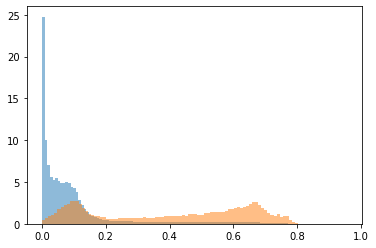

In [264]:
a = plt.hist(predictions[train_md['any'].values == 0], bins=100, density=True, alpha=0.5)
a = plt.hist(predictions[train_md['any'].values == 1], bins=100, density=True, alpha=0.5)

In [191]:
scores = fi.max(0)
significant_cols = scores[scores < 0].index.values
significant_cols

array(['BitsStored', 'PixelRepresentation', 'WindowCenter_1_NAN',
       'ImageOrientationPatient_4', 'ImagePositionPatient_0',
       'ImagePositionPatient_1', 'PixelSpacing_0', 'PixelSpacing_1',
       'WindowCenter_0', 'WindowCenter_1', 'pos_max', 'pos_min',
       'pos_size', 'pos_idx', 'pos_inc'], dtype=object)

In [46]:
significant_cols = ['PixelRepresentation', 'ImageOrientationPatient_4',
       'ImagePositionPatient_0', 'ImagePositionPatient_1',
       'ImagePositionPatient_2', 'PixelSpacing_0', 'PixelSpacing_1',
       'WindowCenter_0']
significant_cols = ['BitsStored', 'PixelRepresentation', 'WindowCenter_1_NAN',
       'ImageOrientationPatient_4', 'ImagePositionPatient_0',
       'ImagePositionPatient_1', 'PixelSpacing_0', 'PixelSpacing_1',
       'WindowCenter_0', 'WindowCenter_1', 'pos_max', 'pos_min',
       'pos_size', 'pos_idx', 'pos_inc']

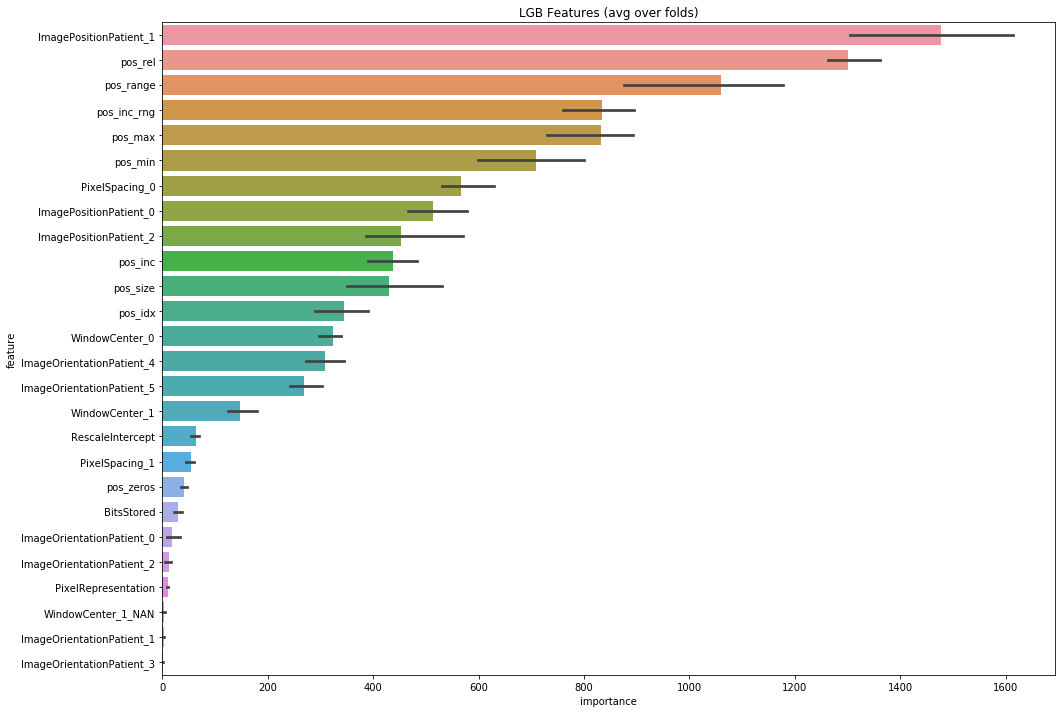

In [265]:
fi['score'] = fi[["feature", "importance"]].groupby('feature').transform('mean')

cols = fi[["feature", "importance"]].groupby("feature").mean().sort_values(
    by="importance", ascending=False)[:50].index
best_features = fi.loc[fi.feature.isin(cols)]

plt.figure(figsize=(16, 12));
sn.barplot(x="importance", y="feature", data=best_features.sort_values(by="score", ascending=False));
plt.title('LGB Features (avg over folds)');

# Prediction

In [266]:
test_md_filt = test_md.loc[:,cols_cat + cols_float]
preds = np.zeros((FOLDS,len(test_md)))
for i in range(FOLDS):
    preds[i,:] = models[i].predict(test_md_filt, num_iteration=models[i].best_iteration)

In [267]:
preds = preds.mean(0)

In [64]:
#preds = preds.mean(0)
preds = np.exp(np.log(preds).mean(0))

In [205]:
preds.mean()

0.07402770495814699

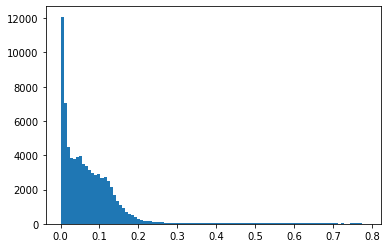

In [268]:
a = plt.hist(preds,bins=100)

In [269]:
predictions.mean()

0.14380767240032438

In [209]:
(predictions*weights).mean()/weights.mean()

0.07663068233421942

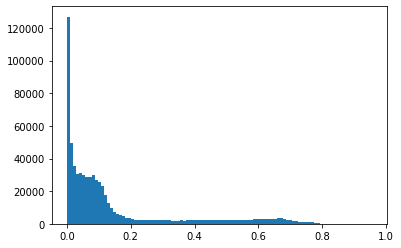

In [270]:
a = plt.hist(predictions,bins=100)

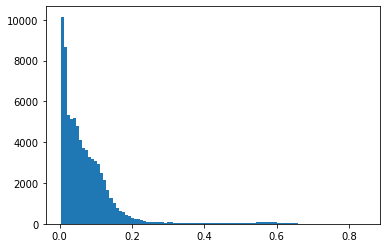

In [211]:
a = plt.hist(predictions,bins=100,weights=weights)

In [271]:
sub = pd.read_csv(PATH/'submission20.csv')

In [185]:
sub.loc[range(0,len(sub),6), 'Label'].mean()

0.1255341744607709

In [272]:
assert np.all(test_md.SOPInstanceUID.apply(lambda x: x + '_any').values == sub.loc[range(0,len(sub),6)].ID.values)

In [273]:
np.corrcoef(sub.loc[range(0,len(sub),6), 'Label'], preds)[0,1]

0.3965943809212345

In [83]:
sub.loc[range(0,len(sub),6), 'Label'] = np.exp(0.95*np.log(sub.loc[range(0,len(sub),6), 'Label']) + 0.05*np.log(preds))

In [274]:
sub.loc[range(0,len(sub),6), 'Label'] = 0.96*sub.loc[range(0,len(sub),6), 'Label'] + 0.04*preds

In [363]:
sub.Label *= 0.98

In [275]:
sub.to_csv(PATH/'submission.csv', index=False)

# Confusion matrix

In [5]:
mat = np.array(train_df.loc[:,train_df.columns[:6]].values, dtype=float)
np.matmul(mat.transpose(),mat)

array([[97103.,  2761., 32564., 23766., 32122., 42496.],
       [ 2761.,  2761.,   556.,   216.,   484.,   645.],
       [32564.,   556., 32564.,  9616.,  8321.,  6541.],
       [23766.,   216.,  9616., 23766.,  6735.,  3404.],
       [32122.,   484.,  8321.,  6735., 32122.,  8505.],
       [42496.,   645.,  6541.,  3404.,  8505., 42496.]])

In [6]:
mat.mean(0)

array([0.144 , 0.0041, 0.0483, 0.0352, 0.0476, 0.063 ])

In [348]:
for i in range(6):
    print(sub.loc[range(i,len(sub),6), 'Label'].mean())

0.12304686302872321
0.003958621945498708
0.04364857134731329
0.0272813377865004
0.04397713774839064
0.0517257743941261


In [7]:
np.set_printoptions(precision=4)
mat /= np.sqrt(mat.sum(0))
np.matmul(mat.transpose(),mat)

array([[1.    , 0.1686, 0.5791, 0.4947, 0.5752, 0.6615],
       [0.1686, 1.    , 0.0586, 0.0267, 0.0514, 0.0595],
       [0.5791, 0.0586, 1.    , 0.3457, 0.2573, 0.1758],
       [0.4947, 0.0267, 0.3457, 1.    , 0.2438, 0.1071],
       [0.5752, 0.0514, 0.2573, 0.2438, 1.    , 0.2302],
       [0.6615, 0.0595, 0.1758, 0.1071, 0.2302, 1.    ]])